In [1]:
import pennylane as qml
import torch
from torch import nn
from torch.utils.data import DataLoader
from pennylane import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm
import pennylane as pl
from sklearn.datasets import fetch_california_housing

#device = 'cpu' # Cuda support for PennyLane is possible though

In [2]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm
import models.quantum_models as qm
from sklearn.model_selection import train_test_split # forgotten by the author

 First interation first defintion of the model given

In [ ]:
class ClassicalSurrogate(nn.Module):
    def __init__(self, z_function, omega_spectrum):
        super(ClassicalSurrogate, self).__init__()
        self.omegas = omega_spectrum
        self.alpha = nn.Parameter(torch.empty(self.omegas.size(0), dtype=torch.float64))
        self.beta = nn.Parameter(torch.empty(self.omegas.size(0), dtype=torch.float64))
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)
        self.z_function = z_function
    
    def forward(self, x):
        z_x = self.z_function(x)
        dot_products = torch.mm(z_x, self.omegas.t())
        cos_values = torch.cos(dot_products)
        sin_values = torch.sin(dot_products)
        outputs = torch.sum(self.alpha.squeeze() * cos_values + self.beta.squeeze() * sin_values, dim=1)
        return outputs.unsqueeze(1)
    
    def fit_fourier_coefficients(self, X, Y):
        with torch.no_grad():
            z_x = self.z_function(X)
            dot_products = torch.mm(z_x, self.omegas.t())
            cos_values = torch.cos(dot_products)
            sin_values = torch.sin(dot_products)
            features = torch.cat([cos_values, sin_values], dim=1)
            coefficients = torch.linalg.lstsq(features, Y, driver='gelsd').solution.squeeze()
            self.alpha.data = coefficients[:self.omegas.size(0)]
            self.beta.data = coefficients[self.omegas.size(0):]
+

Data visualization

In [3]:
# load california housing dataset
data = fetch_california_housing()
X = torch.from_numpy(data.data)
y = torch.from_numpy(data.target)
print(y)
print(X)
print(max(y))
print(min(y))



tensor([4.5260, 3.5850, 3.5210,  ..., 0.9230, 0.8470, 0.8940],
       dtype=torch.float64)
tensor([[   8.3252,   41.0000,    6.9841,  ...,    2.5556,   37.8800,
         -122.2300],
        [   8.3014,   21.0000,    6.2381,  ...,    2.1098,   37.8600,
         -122.2200],
        [   7.2574,   52.0000,    8.2881,  ...,    2.8023,   37.8500,
         -122.2400],
        ...,
        [   1.7000,   17.0000,    5.2055,  ...,    2.3256,   39.4300,
         -121.2200],
        [   1.8672,   18.0000,    5.3295,  ...,    2.1232,   39.4300,
         -121.3200],
        [   2.3886,   16.0000,    5.2547,  ...,    2.6170,   39.3700,
         -121.2400]], dtype=torch.float64)
tensor(5.0000, dtype=torch.float64)
tensor(0.1500, dtype=torch.float64)


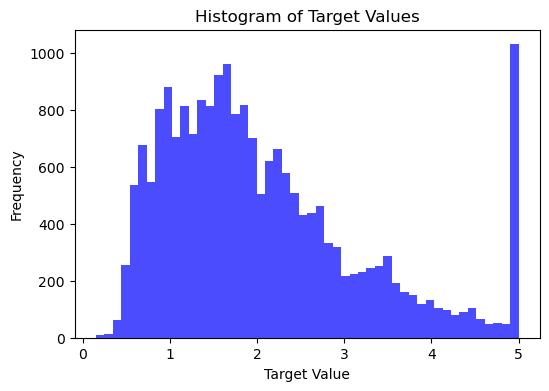

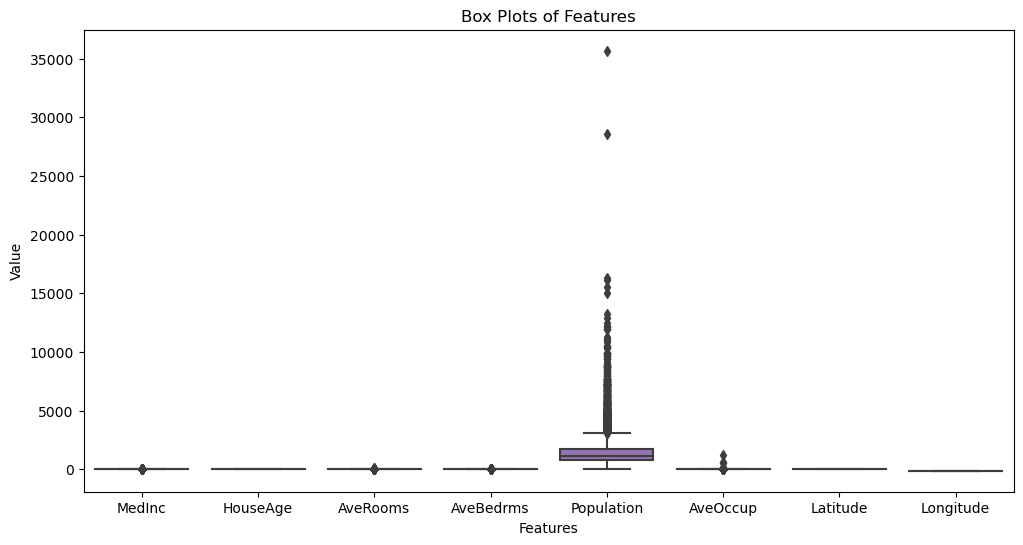

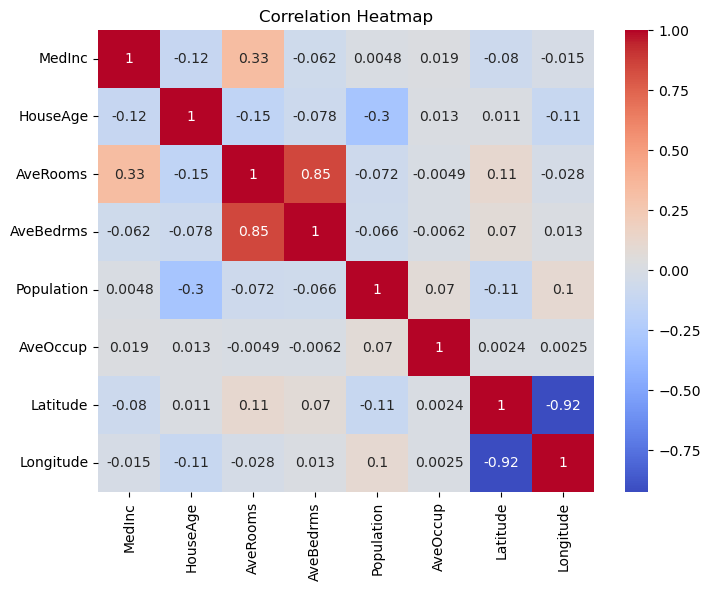

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
import torch

# Load California housing dataset
data = fetch_california_housing()
X = torch.from_numpy(data.data)
y = torch.from_numpy(data.target)

# Convert tensors to numpy arrays for easier plotting
X_np = X.numpy()
y_np = y.numpy()

# Plot 1: Histogram of target values
plt.figure(figsize=(6, 4))
plt.hist(y_np, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()

# Plot 2: Box Plots of Features
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_np)
plt.title('Box Plots of Features')
plt.xlabel('Features')
plt.ylabel('Value')
plt.xticks(ticks=range(X_np.shape[1]), labels=data.feature_names)
plt.show()

# Plot 3: Correlation Heatmap
correlation_matrix = np.corrcoef(X_np, rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
            xticklabels=data.feature_names, 
            yticklabels=data.feature_names)
plt.title('Correlation Heatmap')
plt.show()


In [5]:
# Scale data to interval [-pi/2, pi/2]
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# torch dataloaders
train_data_list = []
for i in range(len(X_train)):
    data_point = (X_train[i], y_train[i])
    train_data_list.append(data_point)

test_data_list = []
for i in range(len(X_test)):
    data_point = (X_test[i], y_test[i])
    test_data_list.append(data_point)
    
train_dataloader = DataLoader(train_data_list, batch_size=500, shuffle=True)
test_dataloader = DataLoader(test_data_list, batch_size=500, shuffle=True)


- I added a boxplot to visualize the distribution of the scaled features, offering insight into the data's distribution after scaling.
- I printed the shapes of the training and test datasets post-split to verify the intended partitioning.
- I displayed the first few training data points to closely examine the data structure.
- I printed the number of batches in both the `train_dataloader` and `test_dataloader` to ensure their correct setup.

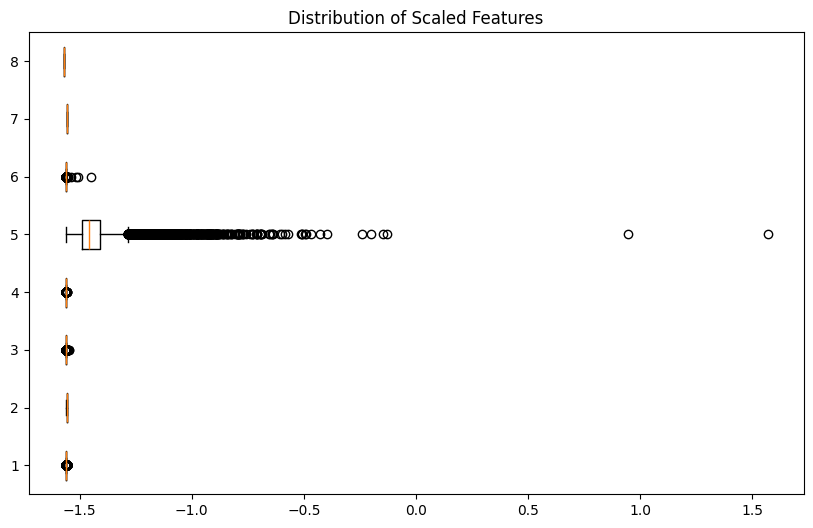

X_train shape: torch.Size([16512, 8])
X_test shape: torch.Size([4128, 8])
y_train shape: torch.Size([16512])
y_test shape: torch.Size([4128])

First 5 training data points:
Data point 1 - Features: tensor([-1.5598, -1.5594, -1.5595, -1.5598, -1.4373, -1.5596, -1.5567, -1.5704],
       dtype=torch.float64), Target: 0.72
Data point 2 - Features: tensor([-1.5593, -1.5592, -1.5594, -1.5598, -1.4843, -1.5597, -1.5569, -1.5702],
       dtype=torch.float64), Target: 2.741
Data point 3 - Features: tensor([-1.5597, -1.5577, -1.5595, -1.5598, -1.4782, -1.5595, -1.5567, -1.5704],
       dtype=torch.float64), Target: 0.583
Data point 4 - Features: tensor([-1.5598, -1.5572, -1.5596, -1.5598, -1.5075, -1.5597, -1.5569, -1.5703],
       dtype=torch.float64), Target: 2.0
Data point 5 - Features: tensor([-1.5595, -1.5580, -1.5594, -1.5598, -1.4607, -1.5596, -1.5566, -1.5705],
       dtype=torch.float64), Target: 1.179

Number of batches in train_dataloader: 34
Number of batches in test_dataloader: 9


In [26]:
# Visualization after scaling
plt.figure(figsize=(10, 6))
plt.title("Distribution of Scaled Features")
plt.boxplot(X_scaled.numpy(), vert=False)  # Boxplot to visualize the distribution of scaled features
plt.show()

# Print shapes to check the splitting
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Visualization of first few training data points (features and target)
print("\nFirst 5 training data points:")
for i in range(5):
    print(f"Data point {i+1} - Features: {train_data_list[i][0]}, Target: {train_data_list[i][1]}")
# Print to check DataLoader
print(f"\nNumber of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")

# The Classical Surrogate

In [43]:
# generate frequencies
max_freq = 2
dim = X_scaled[0].shape[0]

W = utils.freq_generator(max_freq, dim, mode="half")

# What does this function do ? Does it call the other twices ? How are the train and test functions used ?

In [44]:
# defining and training the model
NN_loss = []
NN_test_loss = []
#W.to(device)
model = fm.Fourier_model(W)
#model.to(device)
loss_fn = nn.MSELoss(reduction='mean') 
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    NN_loss.append(test(train_dataloader, model, loss_fn))
    NN_test_loss.append(test(test_dataloader, model, loss_fn))    
    print("Done!")

Epoch 1
-------------------------------
Batch 0: Loss 1.2483253822922027
Test Error: 
 Accuracy: 0.0%, Avg loss: 75.595206 

Test Error: 
 Accuracy: 0.0%, Avg loss: 7.938312 

Done!
Epoch 2
-------------------------------
Batch 0: Loss 0.5299025127581335
Test Error: 
 Accuracy: 0.0%, Avg loss: 37.376410 

Test Error: 
 Accuracy: 0.0%, Avg loss: 2.941785 

Done!
Epoch 3
-------------------------------
Batch 0: Loss 0.4233408861971628
Test Error: 
 Accuracy: 0.0%, Avg loss: 2.920964 

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.621747 

Done!
Epoch 4
-------------------------------
Batch 0: Loss 0.4870427003697296
Test Error: 
 Accuracy: 0.0%, Avg loss: 2.916224 

Test Error: 
 Accuracy: 0.0%, Avg loss: 1.751417 

Done!
Epoch 5
-------------------------------
Batch 0: Loss 0.4024527686865697
Test Error: 
 Accuracy: 0.0%, Avg loss: 58112.992874 

Test Error: 
 Accuracy: 0.0%, Avg loss: 145.078516 

Done!
Epoch 6
-------------------------------
Batch 0: Loss 0.5140009376171009
Test Error: 
 

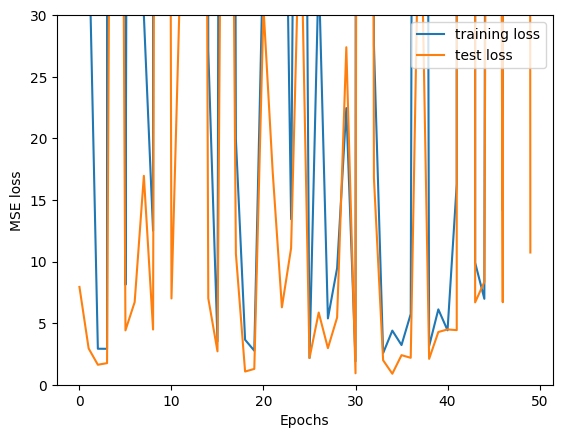

In [45]:
x = np.arange(0, len(NN_loss), 1)
plt.plot(x, NN_loss, color="C0", label="training loss")
plt.plot(x, NN_test_loss, color="C1", label="test loss")
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.ylim(0,30)
plt.legend()

# Modified

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming utils.data_scaler and fetch_california_housing are already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Scale data to interval [-pi/2, pi/2]
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training + validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=2)  # 20% of the original training set will be used for validation

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False)  # Usually, we do not need to shuffle the validation and test sets
test_dataloader = DataLoader(test_dataset, batch_size=500, shuffle=False)


In [21]:
# Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0

    for X, y in dataloader:
        # Define the closure function
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output.squeeze(), y)  # Ensure the output and y have the same shape
            loss.backward()
            return loss

        # Call the optimizer step with the closure function
        optimizer.step(closure)
        total_loss += closure().item()  # You need to call closure() again to get the loss value

    average_loss = total_loss / len(dataloader.dataset)
    return average_loss


# Define evaluation function for both validation and test sets
def evaluate(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    total_absolute_relative_error = 0
    predictions, targets = [], []

    with torch.no_grad():
        for X, y in dataloader:
            output = model(X).squeeze()  # Squeeze the output here as well
            total_loss += loss_fn(output, y).item()
            total_absolute_relative_error += torch.abs((y - output) / torch.clamp(y, min=1e-6)).sum().item()
            predictions.extend(output.tolist())
            targets.extend(y.tolist())

    average_loss = total_loss / len(dataloader.dataset)
    avg_mare = total_absolute_relative_error / len(dataloader.dataset)
    r2 = r2_score(targets, predictions)
    return average_loss, avg_mare, r2


Epoch 1
-------------------------------
Train Loss: 0.0018
Validation Loss: 0.0023, Validation MARE: 0.3888, Validation R^2: 0.1568
Done!
Epoch 2
-------------------------------
Train Loss: 0.0015
Validation Loss: 0.0017, Validation MARE: 0.3351, Validation R^2: 0.3838
Done!
Epoch 3
-------------------------------
Train Loss: 0.0011
Validation Loss: 0.0013, Validation MARE: 0.3440, Validation R^2: 0.5314
Done!
Epoch 4
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0016, Validation MARE: 0.3550, Validation R^2: 0.4244
Done!
Epoch 5
-------------------------------
Train Loss: 0.0012
Validation Loss: 0.0019, Validation MARE: 0.3588, Validation R^2: 0.3114
Done!
Epoch 6
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0018, Validation MARE: 0.3417, Validation R^2: 0.3528
Done!
Epoch 7
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0035, Validation MARE: 0.3663, Validation R^2: -0.2827
Done!
Epoch 8
-------------------------

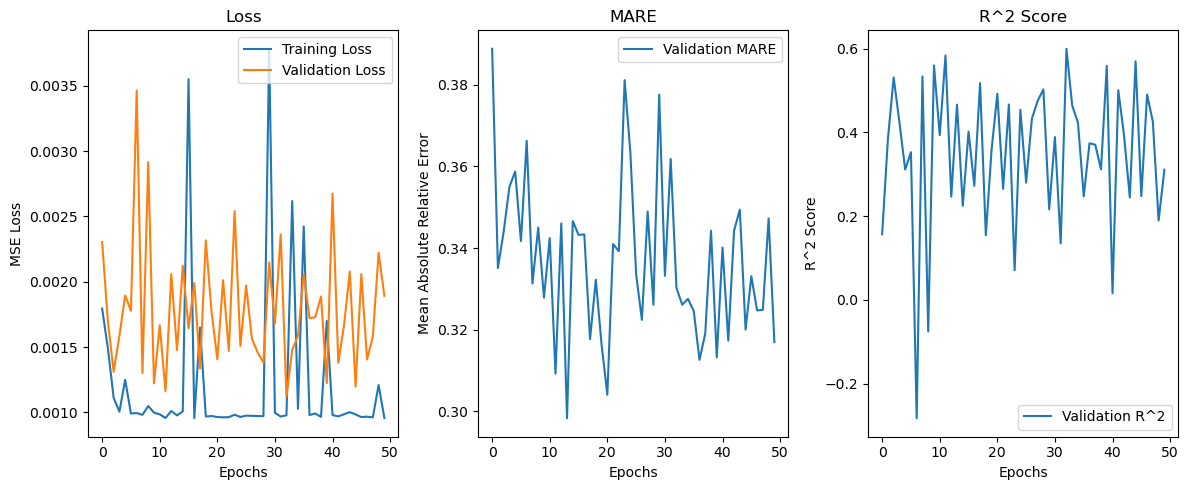

Test Loss: 0.0014, Test MARE: 0.3091, Test R^2: 0.5088


In [22]:

from sklearn.metrics import r2_score

# Generate frequencies
max_freq = 2
dim = X_scaled.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]

W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r2 = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r2 = evaluate(val_dataloader, model, loss_fn)  # Use the evaluate function for validation

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r2.append(val_r2)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation MARE: {val_mare:.4f}, Validation R^2: {val_r2:.4f}")
    print("Done!")


# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

# Plot validation MARE
plt.subplot(1, 3, 2)
plt.plot(x, NN_val_mare, label="Validation MARE")
plt.title('MARE')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Relative Error")
plt.legend()

# Plot validation R^2
plt.subplot(1, 3, 3)
plt.plot(x, NN_val_r2, label="Validation R^2")
plt.title('R^2 Score')
plt.xlabel("Epochs")
plt.ylabel("R^2 Score")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r2 = evaluate(test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R^2: {test_r2:.4f}")

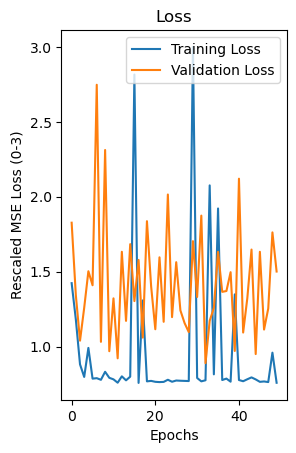

In [28]:
import matplotlib.pyplot as plt

# Assuming you have x, NN_loss, and NN_val_loss defined

# Rescale the data to have y values in the range [0, 3]
rescale_factor = 3 / max(max(NN_loss), max(NN_val_loss))
scaled_NN_loss = [loss * rescale_factor for loss in NN_loss]
scaled_NN_val_loss = [val_loss * rescale_factor for val_loss in NN_val_loss]

# Plot the rescaled training and validation loss
plt.subplot(1, 2, 1)
plt.plot(x, scaled_NN_loss, label="Training Loss")
plt.plot(x, scaled_NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Rescaled MSE Loss (0-3)")
plt.legend()

# Show the plot
plt.show()


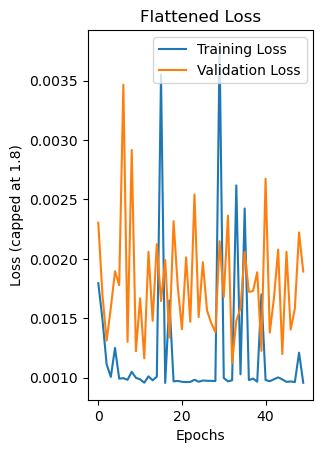

In [29]:
def flatten_peaks(data, peak_threshold, max_value):
    scaled_data = []
    for value in data:
        if value <= peak_threshold:
            # Below the threshold, scale linearly
            scaled_data.append(value * (max_value / peak_threshold))
        else:
            # Above the threshold, scale down to fit between peak_threshold and max_value
            scaled_value = peak_threshold + (value - peak_threshold) * ((max_value - peak_threshold) / (max(value) - peak_threshold))
            scaled_data.append(scaled_value)
    return scaled_data

# Use this function to flatten the peaks of NN_loss and NN_val_loss
peak_threshold = 1.8  # Set the peak threshold
max_allowed_value = 1.8  # Set the maximum allowed value after scaling

# Apply the transformation to flatten the peaks
flattened_NN_loss = flatten_peaks(NN_loss, peak_threshold, max_allowed_value)
flattened_NN_val_loss = flatten_peaks(NN_val_loss, peak_threshold, max_allowed_value)

# Plot the flattened training and validation loss
plt.subplot(1, 2, 1)
plt.plot(x, flattened_NN_loss, label="Training Loss")
plt.plot(x, flattened_NN_val_loss, label="Validation Loss")
plt.title('Flattened Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (capped at 1.8)")
plt.legend()

# Show the plot
plt.show()


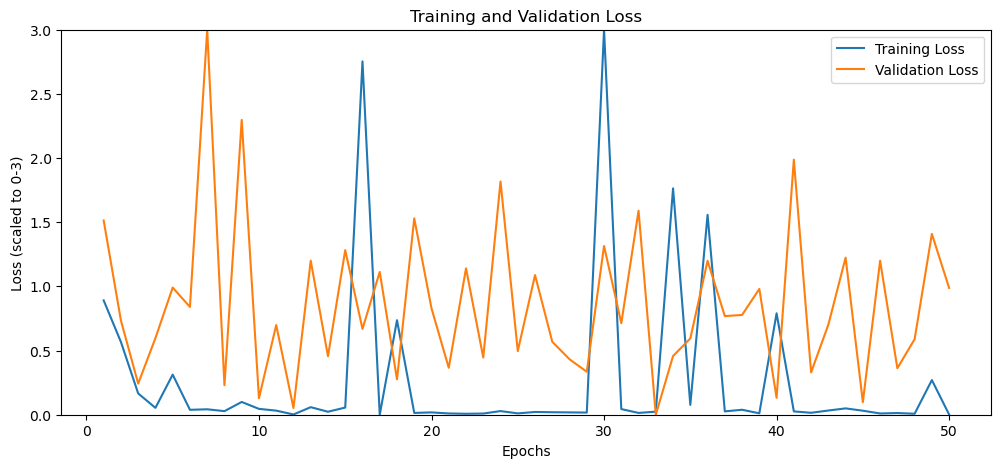

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the moving average using numpy
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Function to scale the data
def scale_data(data, min_val, max_val):
    data_min = min(data)
    data_max = max(data)
    return [(datum - data_min) / (data_max - data_min) * (max_val - min_val) + min_val for datum in data]

# The size of the moving window for the moving average
window_size = 1

# Smooth the data
smoothed_NN_loss = moving_average(NN_loss, window_size)
smoothed_NN_val_loss = moving_average(NN_val_loss, window_size)

# Scale the smoothed data to a range of 0 to 3
scaled_smoothed_NN_loss = scale_data(smoothed_NN_loss, 0, 3)
scaled_smoothed_NN_val_loss = scale_data(smoothed_NN_val_loss, 0, 3)

# Create a range for the epochs
epochs_range = np.arange(1, epochs + 1)

# Plot the scaled and smoothed data
plt.figure(figsize=(12, 5))
plt.plot(epochs_range, scaled_smoothed_NN_loss, label='Training Loss')
plt.plot(epochs_range, scaled_smoothed_NN_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (scaled to 0-3)')
plt.ylim(0, 3)
plt.legend()
plt.show()


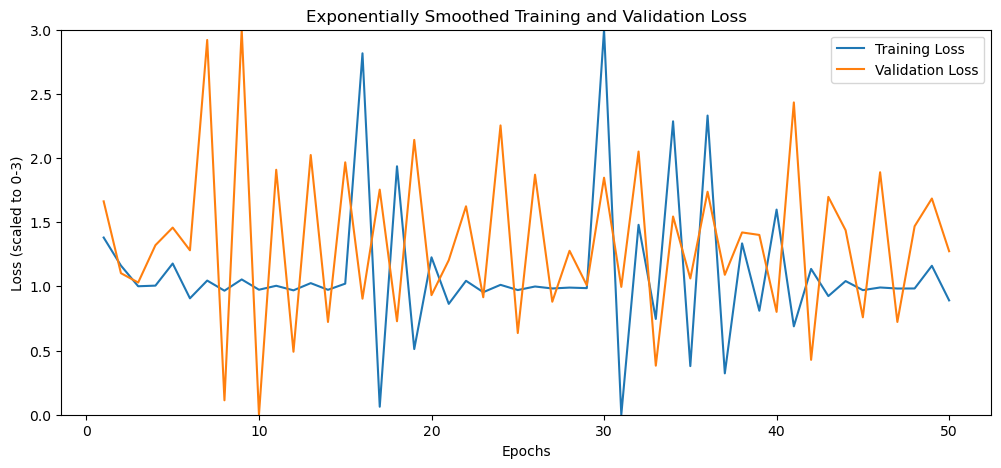

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Function for exponential smoothing
def exponential_smoothing(data, alpha):
    smoothed_data = [data[0]]  # First data point is the same
    for point in data[1:]:
        smoothed_data.append(alpha * point + (1 - alpha) * smoothed_data[-1])
    return smoothed_data

# The smoothing factor, alpha, is between 0 and 1.
# Smaller alpha will result in smoother data
alpha = 1.5 # You can adjust this value to control the smoothing

# Apply exponential smoothing
exp_smoothed_NN_loss = exponential_smoothing(NN_loss, alpha)
exp_smoothed_NN_val_loss = exponential_smoothing(NN_val_loss, alpha)

# Scale the smoothed data to the range [0, 3]
scaled_exp_smoothed_NN_loss = scale_data(exp_smoothed_NN_loss, 0, 3)
scaled_exp_smoothed_NN_val_loss = scale_data(exp_smoothed_NN_val_loss, 0, 3)

# Plot the scaled and smoothed data
plt.figure(figsize=(12, 5))
plt.plot(range(1, epochs + 1), scaled_exp_smoothed_NN_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), scaled_exp_smoothed_NN_val_loss, label='Validation Loss')
plt.title('Exponentially Smoothed Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (scaled to 0-3)')
plt.ylim(0, 3)
plt.legend()
plt.show()


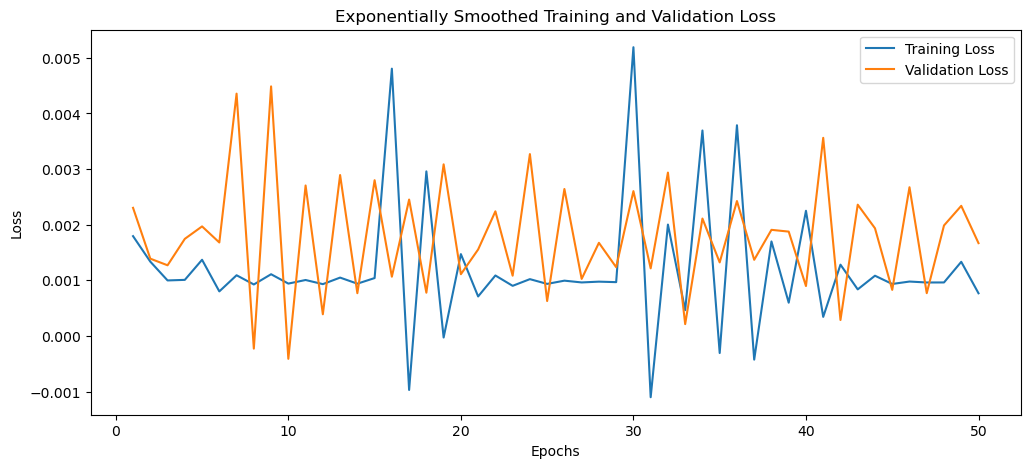

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have 'NN_loss' and 'NN_val_loss' defined from your training loop
# and 'epochs' is the number of epochs you trained for

# Function for exponential smoothing
def exponential_smoothing(data, alpha):
    smoothed_data = [data[0]]  # First data point is the same
    for point in data[1:]:
        smoothed_data.append(alpha * point + (1 - alpha) * smoothed_data[-1])
    return smoothed_data

# The smoothing factor, alpha, is between 0 and 1.
# Smaller alpha will result in smoother data
alpha = 1.5 # You can adjust this value to control the smoothing

# Apply exponential smoothing
exp_smoothed_NN_loss = exponential_smoothing(NN_loss, alpha)
exp_smoothed_NN_val_loss = exponential_smoothing(NN_val_loss, alpha)

# Plot the smoothed data
plt.figure(figsize=(12, 5))
plt.plot(range(1, len(NN_loss) + 1), exp_smoothed_NN_loss, label='Training Loss')
plt.plot(range(1, len(NN_val_loss) + 1), exp_smoothed_NN_val_loss, label='Validation Loss')
plt.title('Exponentially Smoothed Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Higher frequency to capture more complexity ?

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming utils.data_scaler and fetch_california_housing are already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Scale data to interval [-pi/2, pi/2]
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training + validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=2)  # 20% of the original training set will be used for validation

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)  # Usually, we do not need to shuffle the validation and test sets
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)


In [6]:
# Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0

    for X, y in dataloader:
        # Define the closure function
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output.squeeze(), y)  # Ensure the output and y have the same shape
            loss.backward()
            return loss

        # Call the optimizer step with the closure function
        optimizer.step(closure)
        total_loss += closure().item()  # You need to call closure() again to get the loss value

    average_loss = total_loss / len(dataloader.dataset)
    return average_loss


# Define evaluation function for both validation and test sets
def evaluate(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    total_absolute_relative_error = 0
    predictions, targets = [], []

    with torch.no_grad():
        for X, y in dataloader:
            output = model(X).squeeze()  # Squeeze the output here as well
            total_loss += loss_fn(output, y).item()
            total_absolute_relative_error += torch.abs((y - output) / torch.clamp(y, min=1e-6)).sum().item()
            predictions.extend(output.tolist())
            targets.extend(y.tolist())

    average_loss = total_loss / len(dataloader.dataset)
    avg_mare = total_absolute_relative_error / len(dataloader.dataset)
    r2 = r2_score(targets, predictions)
    return average_loss, avg_mare, r2


In [7]:

from sklearn.metrics import r2_score

# Generate frequencies
max_freq = 3
dim = X_scaled.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]

W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r2 = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r2 = evaluate(val_dataloader, model, loss_fn)  # Use the evaluate function for validation

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r2.append(val_r2)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation MARE: {val_mare:.4f}, Validation R^2: {val_r2:.4f}")
    print("Done!")


# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

# Plot validation MARE
plt.subplot(1, 3, 2)
plt.plot(x, NN_val_mare, label="Validation MARE")
plt.title('MARE')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Relative Error")
plt.legend()

# Plot validation R^2
plt.subplot(1, 3, 3)
plt.plot(x, NN_val_r2, label="Validation R^2")
plt.title('R^2 Score')
plt.xlabel("Epochs")
plt.ylabel("R^2 Score")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r2 = evaluate(test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R^2: {test_r2:.4f}")

Epoch 1
-------------------------------
Train Loss: 0.0113
Validation Loss: 0.2029, Validation MARE: 0.8839, Validation R^2: -6.6854
Done!
Epoch 2
-------------------------------
Train Loss: 0.0131
Validation Loss: 0.2225, Validation MARE: 0.6303, Validation R^2: -7.4480
Done!
Epoch 3
-------------------------------
Train Loss: 0.0078
Validation Loss: 0.3924, Validation MARE: 0.9949, Validation R^2: -13.8448
Done!
Epoch 4
-------------------------------
Train Loss: 0.0102
Validation Loss: 5.9585, Validation MARE: 1.7175, Validation R^2: -225.2082
Done!
Epoch 5
-------------------------------
Train Loss: 0.0108
Validation Loss: 0.0546, Validation MARE: 0.5087, Validation R^2: -1.0713
Done!
Epoch 6
-------------------------------
Train Loss: 0.0091
Validation Loss: 0.5335, Validation MARE: 1.0902, Validation R^2: -19.2198
Done!
Epoch 7
-------------------------------
Train Loss: 0.0087
Validation Loss: 0.0551, Validation MARE: 0.7360, Validation R^2: -1.0764
Done!
Epoch 8
---------------

KeyboardInterrupt: 

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming utils.data_scaler and fetch_california_housing are already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Scale data to interval [-pi/2, pi/2]
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training + validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=2)  # 20% of the original training set will be used for validation

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=500, shuffle=False)  # Usually, we do not need to shuffle the validation and test sets
test_dataloader = DataLoader(test_dataset, batch_size=500, shuffle=False)


Epoch 1
-------------------------------
Train Loss: 0.0017
Validation Loss: 0.0020, Validation MARE: 0.3495, Validation R^2: 0.2707
Done!
Epoch 2
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0034, Validation MARE: 0.3244, Validation R^2: -0.2546
Done!
Epoch 3
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0078, Validation MARE: 0.3569, Validation R^2: -1.9395
Done!
Epoch 4
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0017, Validation MARE: 0.3297, Validation R^2: 0.3645
Done!
Epoch 5
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0016, Validation MARE: 0.3185, Validation R^2: 0.4178
Done!
Epoch 6
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0015, Validation MARE: 0.3286, Validation R^2: 0.4472
Done!
Epoch 7
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0014, Validation MARE: 0.3505, Validation R^2: 0.4980
Done!
Epoch 8
------------------------

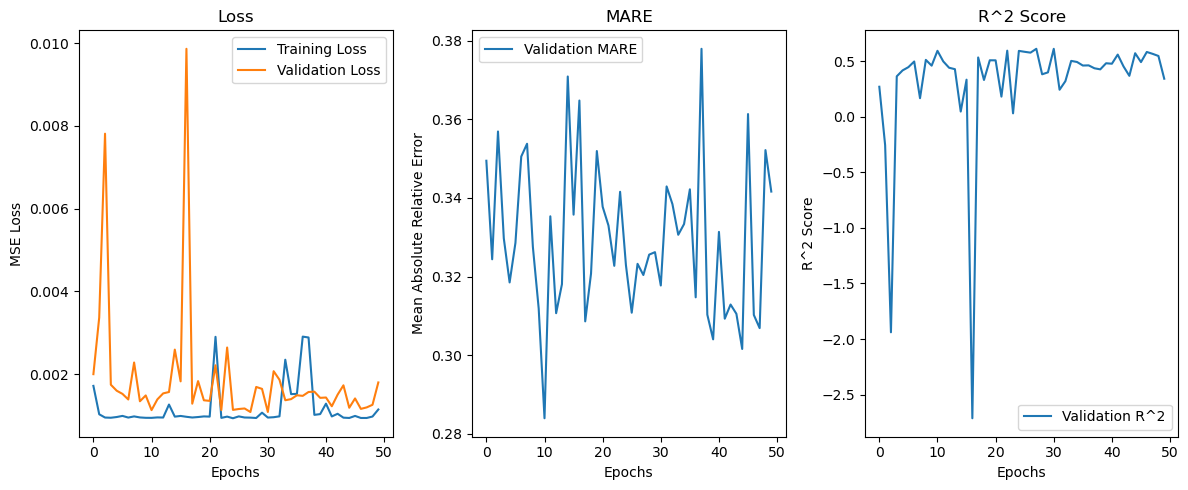

Test Loss: 0.0031, Test MARE: 0.3374, Test R^2: -0.1161


In [10]:

from sklearn.metrics import r2_score

# Generate frequencies
max_freq = 1
dim = X_scaled.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]

W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r2 = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r2 = evaluate(val_dataloader, model, loss_fn)  # Use the evaluate function for validation

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r2.append(val_r2)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation MARE: {val_mare:.4f}, Validation R^2: {val_r2:.4f}")
    print("Done!")


# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

# Plot validation MARE
plt.subplot(1, 3, 2)
plt.plot(x, NN_val_mare, label="Validation MARE")
plt.title('MARE')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Relative Error")
plt.legend()

# Plot validation R^2
plt.subplot(1, 3, 3)
plt.plot(x, NN_val_r2, label="Validation R^2")
plt.title('R^2 Score')
plt.xlabel("Epochs")
plt.ylabel("R^2 Score")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r2 = evaluate(test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R^2: {test_r2:.4f}")

# Batch size plays an important role

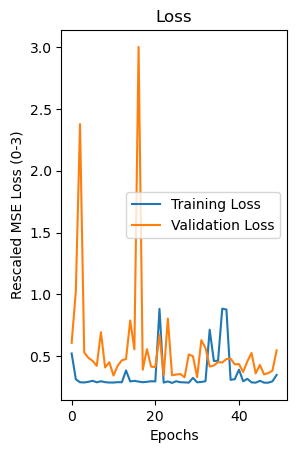

In [11]:
import matplotlib.pyplot as plt

# Assuming you have x, NN_loss, and NN_val_loss defined

# Rescale the data to have y values in the range [0, 3]
rescale_factor = 3 / max(max(NN_loss), max(NN_val_loss))
scaled_NN_loss = [loss * rescale_factor for loss in NN_loss]
scaled_NN_val_loss = [val_loss * rescale_factor for val_loss in NN_val_loss]

# Plot the rescaled training and validation loss
plt.subplot(1, 2, 1)
plt.plot(x, scaled_NN_loss, label="Training Loss")
plt.plot(x, scaled_NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Rescaled MSE Loss (0-3)")
plt.legend()

# Show the plot
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming utils.data_scaler and fetch_california_housing are already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Scale data to interval [-pi/2, pi/2]
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training + validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=2)  # 20% of the original training set will be used for validation

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=False)  # Usually, we do not need to shuffle the validation and test sets
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


Epoch 1
-------------------------------
Train Loss: 0.0010
Validation Loss: 0.0013, Validation MARE: 0.4010, Validation R^2: 0.1106
Done!
Epoch 2
-------------------------------
Train Loss: 0.0006
Validation Loss: 0.0008, Validation MARE: 0.3296, Validation R^2: 0.4878
Done!
Epoch 3
-------------------------------
Train Loss: 0.0005
Validation Loss: 0.0045, Validation MARE: 0.3526, Validation R^2: -2.2828
Done!
Epoch 4
-------------------------------
Train Loss: 0.0005
Validation Loss: 0.0010, Validation MARE: 0.3178, Validation R^2: 0.3454
Done!
Epoch 5
-------------------------------
Train Loss: 0.0005
Validation Loss: 0.0024, Validation MARE: 0.4024, Validation R^2: -0.6526
Done!
Epoch 6
-------------------------------
Train Loss: 0.0005
Validation Loss: 0.0008, Validation MARE: 0.3155, Validation R^2: 0.4931
Done!
Epoch 7
-------------------------------
Train Loss: 0.0005
Validation Loss: 0.0008, Validation MARE: 0.3192, Validation R^2: 0.5006
Done!
Epoch 8
------------------------

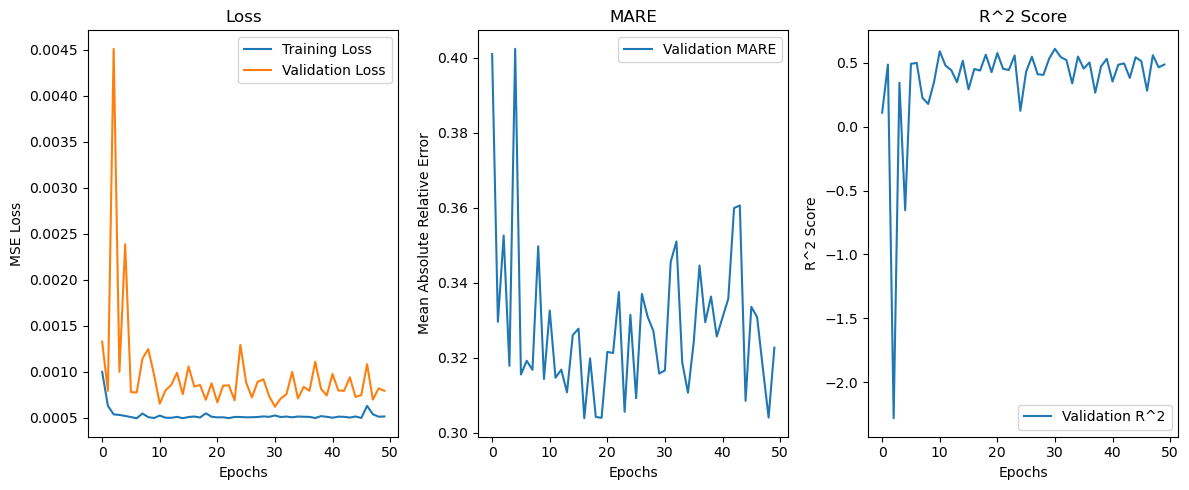

Test Loss: 0.0007, Test MARE: 0.3172, Test R^2: 0.5841


In [19]:

from sklearn.metrics import r2_score

# Generate frequencies
max_freq = 1
dim = X_scaled.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]

W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r2 = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r2 = evaluate(val_dataloader, model, loss_fn)  # Use the evaluate function for validation

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r2.append(val_r2)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation MARE: {val_mare:.4f}, Validation R^2: {val_r2:.4f}")
    print("Done!")


# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()

# Plot validation MARE
plt.subplot(1, 3, 2)
plt.plot(x, NN_val_mare, label="Validation MARE")
plt.title('MARE')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Relative Error")
plt.legend()

# Plot validation R^2
plt.subplot(1, 3, 3)
plt.plot(x, NN_val_r2, label="Validation R^2")
plt.title('R^2 Score')
plt.xlabel("Epochs")
plt.ylabel("R^2 Score")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r2 = evaluate(test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R^2: {test_r2:.4f}")

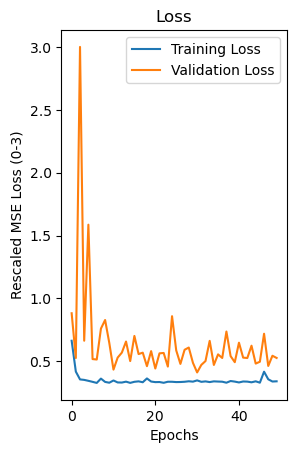

In [20]:
import matplotlib.pyplot as plt

# Assuming you have x, NN_loss, and NN_val_loss defined

# Rescale the data to have y values in the range [0, 3]
rescale_factor = 3 / max(max(NN_loss), max(NN_val_loss))
scaled_NN_loss = [loss * rescale_factor for loss in NN_loss]
scaled_NN_val_loss = [val_loss * rescale_factor for val_loss in NN_val_loss]

# Plot the rescaled training and validation loss
plt.subplot(1, 2, 1)
plt.plot(x, scaled_NN_loss, label="Training Loss")
plt.plot(x, scaled_NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Rescaled MSE Loss (0-3)")
plt.legend()

# Show the plot
plt.show()

### Several Runs


In [25]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming utils.data_scaler and fetch_california_housing are already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Scale data to interval [-pi/2, pi/2]
X_scaled = utils.data_scaler(X, interval=(-torch.pi/2, torch.pi/2))

# Split the data set into training + validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=2)  # 20% of the original training set will be used for validation

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=False)  # Usually, we do not need to shuffle the validation and test sets
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
----------------

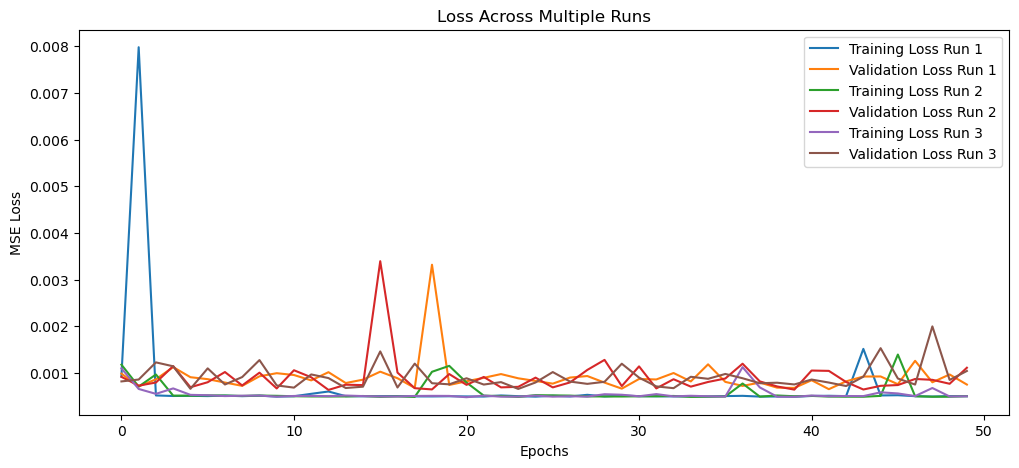

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ... (other necessary imports and setup code)

# Initialize lists to store loss values for each run
all_NN_loss = []
all_NN_val_loss = []

def run_experiment():
    # Initialize the model
    model = fm.Fourier_model(W).float()
    
    # Initialize the optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

    # Prepare lists to store loss and evaluation metrics for the current run
    NN_loss = []
    NN_val_loss = []
    NN_val_mare = []
    NN_val_r2 = []

    # Training loop
    epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        val_loss, val_mare, val_r2 = evaluate(val_dataloader, model, loss_fn)  # Use the evaluate function for validation

        NN_loss.append(train_loss)
        NN_val_loss.append(val_loss)
        NN_val_mare.append(val_mare)
        NN_val_r2.append(val_r2)

    return NN_loss, NN_val_loss

# Define the number of runs you want to execute
num_runs = 3  # For example, 3 runs

for i in range(num_runs):
    NN_loss, NN_val_loss = run_experiment()
    all_NN_loss.append(NN_loss)
    all_NN_val_loss.append(NN_val_loss)

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

for i, (NN_loss, NN_val_loss) in enumerate(zip(all_NN_loss, all_NN_val_loss)):
    plt.plot(x, NN_loss, label=f"Training Loss Run {i+1}")
    plt.plot(x, NN_val_loss, label=f"Validation Loss Run {i+1}")

plt.title('Loss Across Multiple Runs')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
----------------

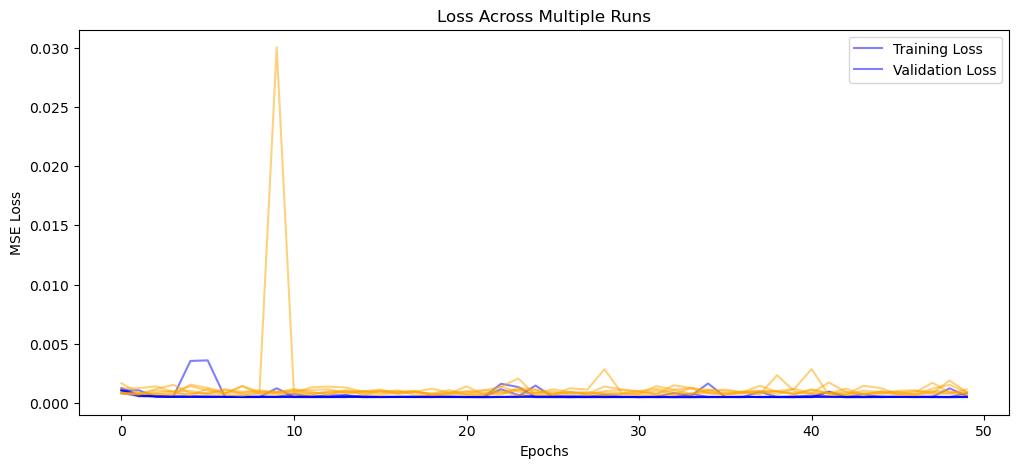

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ... (other necessary imports and setup code)

# Initialize lists to store loss values for each run
all_NN_loss = []
all_NN_val_loss = []

def run_experiment():
    # Initialize the model
    model = fm.Fourier_model(W).float()
    
    # Initialize the optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

    # Prepare lists to store loss and evaluation metrics for the current run
    NN_loss = []
    NN_val_loss = []
    #NN_val_mare = []
    #NN_val_r2 = []

    # Training loop
    epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        val_loss, val_mare, val_r2 = evaluate(val_dataloader, model, loss_fn)  # Use the evaluate function for validation

        NN_loss.append(train_loss)
        NN_val_loss.append(val_loss)
        #NN_val_mare.append(val_mare)
        #NN_val_r2.append(val_r2)

    return NN_loss, NN_val_loss

# Define the number of runs you want to execute
num_runs = 6  # For example, 6 runs

for i in range(num_runs):
    NN_loss, NN_val_loss = run_experiment()
    all_NN_loss.append(NN_loss)
    all_NN_val_loss.append(NN_val_loss)

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

for NN_loss in all_NN_loss:
    plt.plot(x, NN_loss, color='blue', alpha=0.5)  # Set the color to blue and make it slightly transparent

for NN_val_loss in all_NN_val_loss:
    plt.plot(x, NN_val_loss, color='orange', alpha=0.5)  # Set the color to orange and make it slightly transparent

plt.title('Loss Across Multiple Runs')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

# Create custom legends
plt.legend(["Training Loss", "Validation Loss"], loc="upper right")
plt.show()


# Corrected train function 
### rescaling minus pi over 2

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

# Assuming fetch_california_housing is already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Split the dataset into training + validation and testing (hold-out set)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2)  # 25% of X_train_val will be X_val

# Now we scale the data, ensuring no data leakage happens

# Calculate scaling parameters (min and max in this case) only from the training set
min_value, max_value = X_train.min(dim=0)[0], X_train.max(dim=0)[0]

# Scale the training data
X_train_scaled = utils.data_scaler(X_train, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))

# Apply the same scaling to the validation and test data
X_val_scaled = utils.data_scaler(X_val, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))
X_test_scaled = utils.data_scaler(X_test, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))


# Create TensorDatasets and DataLoaders with the scaled data
train_dataset = TensorDataset(X_train_scaled, y_train)
val_dataset = TensorDataset(X_val_scaled, y_val)
test_dataset = TensorDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=500)
test_dataloader = DataLoader(test_dataset, batch_size=500)

# Note: Typically, we do not need to shuffle the validation and test sets

In [12]:
# Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        # Define the closure function
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output.squeeze(), y)  # Compute loss
            loss.backward()  # Perform backpropagation
            return loss

        loss = closure()  # Compute the loss and perform backpropagation
        optimizer.step(closure)  # Update model parameters using the optimizer

        total_loss += loss.item()  # Accumulate the loss

    average_loss_per_batch = total_loss / num_batches  # Calculate the average loss
    return average_loss_per_batch


def evaluate(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            output = model(X).squeeze()  # Compute model output
            loss = loss_fn(output, y).item()  # Calculate loss
            total_loss += loss  # Accumulate the total loss

    num_batches = len(dataloader)
    average_loss_per_batch = total_loss / num_batches  # Calculate the average loss per batch
    
    # Return the average loss per batch
    return average_loss_per_batch

Epoch 1
-------------------------------
Train Loss: 0.6786
Validation Loss: 0.4585
Epoch 2
-------------------------------
Train Loss: 0.4594
Validation Loss: 0.4367
Epoch 3
-------------------------------
Train Loss: 0.4564
Validation Loss: 0.4599
Epoch 4
-------------------------------
Train Loss: 0.4595
Validation Loss: 0.4361
Epoch 5
-------------------------------
Train Loss: 0.4386
Validation Loss: 0.4366
Epoch 6
-------------------------------
Train Loss: 0.4461
Validation Loss: 0.4418
Epoch 7
-------------------------------
Train Loss: 0.4358
Validation Loss: 0.4637
Epoch 8
-------------------------------
Train Loss: 0.4375
Validation Loss: 0.4392
Epoch 9
-------------------------------
Train Loss: 0.4327
Validation Loss: 0.4198
Epoch 10
-------------------------------
Train Loss: 0.4305
Validation Loss: 0.4524
Epoch 11
-------------------------------
Train Loss: 0.4344
Validation Loss: 0.5066
Epoch 12
-------------------------------
Train Loss: 0.4322
Validation Loss: 0.4769
E

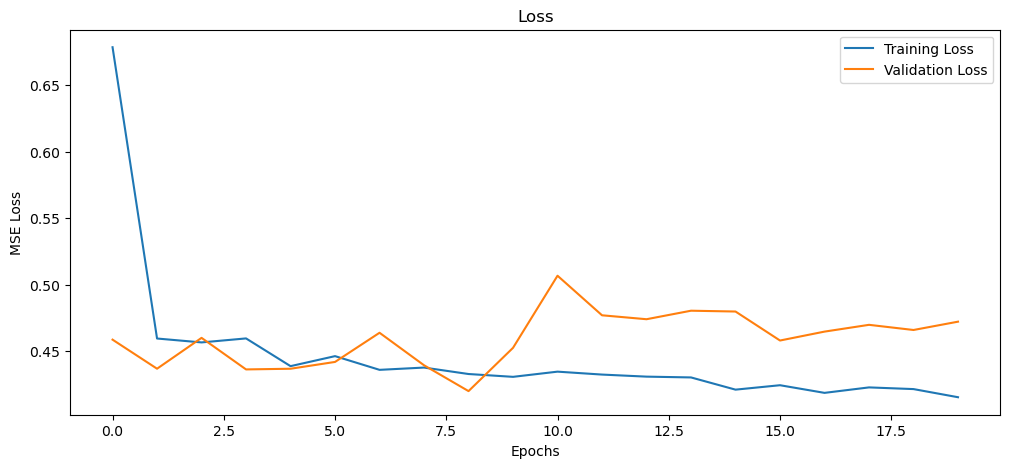

Test Loss: 1.2949


In [5]:

from sklearn.metrics import r2_score

# Generate frequencies
max_freq = 1
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]

W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []


# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = evaluate(val_dataloader, model, loss_fn)  

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
  



# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()


plt.show()

# Evaluate on test data
test_loss = evaluate(test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")

more epochs 

Epoch 1
-------------------------------
Train Loss: 0.6896
Validation Loss: 0.4870
Epoch 2
-------------------------------
Train Loss: 0.4677
Validation Loss: 0.4385
Epoch 3
-------------------------------
Train Loss: 0.4546
Validation Loss: 0.5398
Epoch 4
-------------------------------
Train Loss: 0.4505
Validation Loss: 0.4581
Epoch 5
-------------------------------
Train Loss: 0.4393
Validation Loss: 0.5289
Epoch 6
-------------------------------
Train Loss: 0.4446
Validation Loss: 0.7070
Epoch 7
-------------------------------
Train Loss: 0.4506
Validation Loss: 0.4484
Epoch 8
-------------------------------
Train Loss: 0.4389
Validation Loss: 0.4757
Epoch 9
-------------------------------
Train Loss: 0.4387
Validation Loss: 0.5072
Epoch 10
-------------------------------
Train Loss: 0.4401
Validation Loss: 0.5078
Epoch 11
-------------------------------
Train Loss: 0.4465
Validation Loss: 0.4836
Epoch 12
-------------------------------
Train Loss: 0.4370
Validation Loss: 0.4626
E

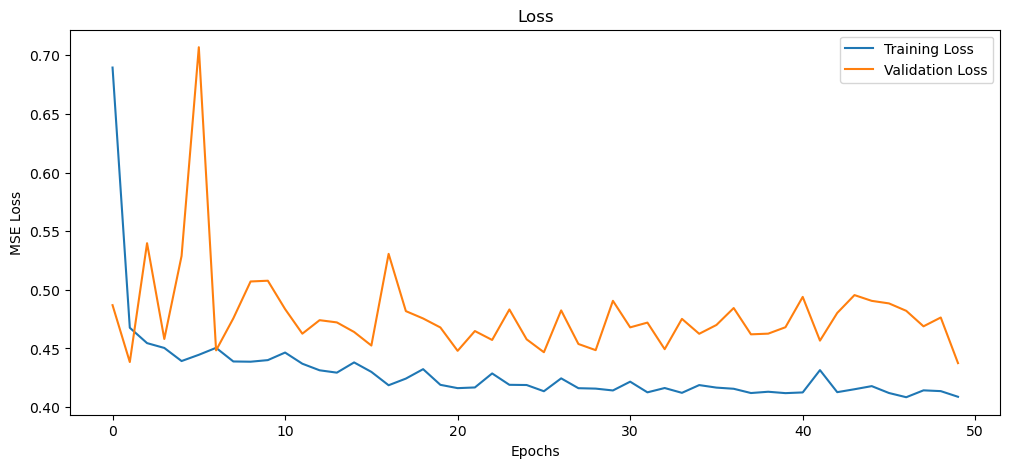

Test Loss: 1.8740


In [6]:

from sklearn.metrics import r2_score

# Generate frequencies
max_freq = 1
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]

W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []


# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = evaluate(val_dataloader, model, loss_fn)  

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
  



# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()


plt.show()

# Evaluate on test data
test_loss = evaluate(test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")

##  frequenncy max 2 minus pi over 2 not done YET


### rescaling o to pi 2
I am lookinfg for the best rescaling so i can then decide of the generation of W all half or positive and max freqency as wel


In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

# Assuming fetch_california_housing is already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Split the dataset into training + validation and testing (hold-out set)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2)  # 25% of X_train_val will be X_val

# Now we scale the data, ensuring no data leakage happens

# Calculate scaling parameters (min and max in this case) only from the training set
min_value, max_value = X_train.min(dim=0)[0], X_train.max(dim=0)[0]

# Scale the training data
X_train_scaled = utils.data_scaler(X_train, min_value=min_value, max_value=max_value, interval=(0, torch.pi*2))

# Apply the same scaling to the validation and test data
X_val_scaled = utils.data_scaler(X_val, min_value=min_value, max_value=max_value, interval=(0, torch.pi*2))
X_test_scaled = utils.data_scaler(X_test, min_value=min_value, max_value=max_value, interval=(0, torch.pi*2))


# Create TensorDatasets and DataLoaders with the scaled data
train_dataset = TensorDataset(X_train_scaled, y_train)
val_dataset = TensorDataset(X_val_scaled, y_val)
test_dataset = TensorDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=500)
test_dataloader = DataLoader(test_dataset, batch_size=500)

# Note: Typically, we do not need to shuffle the validation and test sets

Epoch 1
-------------------------------
Train Loss: 0.8239
Validation Loss: 0.5120
Epoch 2
-------------------------------
Train Loss: 0.5338
Validation Loss: 0.5734
Epoch 3
-------------------------------
Train Loss: 0.5103
Validation Loss: 0.5140
Epoch 4
-------------------------------
Train Loss: 0.5097
Validation Loss: 0.5623
Epoch 5
-------------------------------
Train Loss: 0.5013
Validation Loss: 0.5066
Epoch 6
-------------------------------
Train Loss: 0.4993
Validation Loss: 0.4856
Epoch 7
-------------------------------
Train Loss: 0.4869
Validation Loss: 0.5282
Epoch 8
-------------------------------
Train Loss: 0.4869
Validation Loss: 0.5262
Epoch 9
-------------------------------
Train Loss: 0.4928
Validation Loss: 0.5096
Epoch 10
-------------------------------
Train Loss: 0.4791
Validation Loss: 0.4916
Epoch 11
-------------------------------
Train Loss: 0.4772
Validation Loss: 0.4677
Epoch 12
-------------------------------
Train Loss: 0.4830
Validation Loss: 0.5058
E

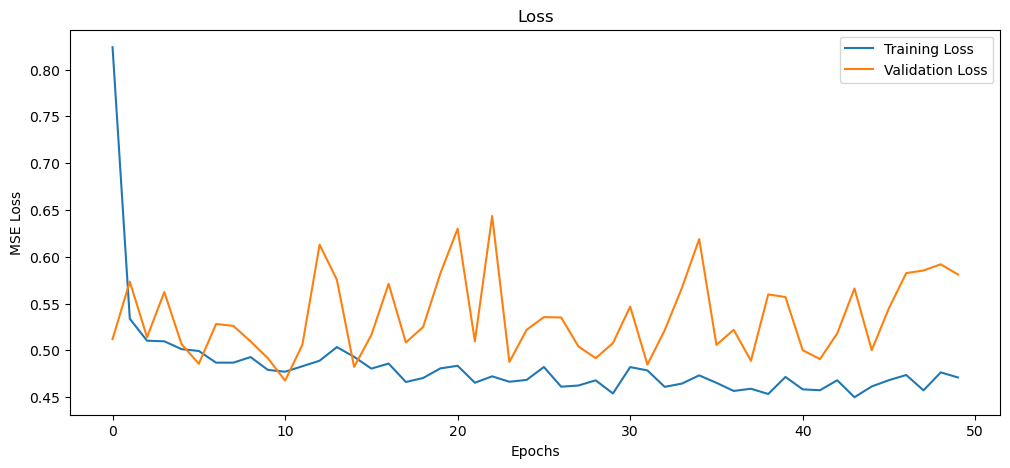

Test Loss: 0.5771


In [9]:

from sklearn.metrics import r2_score

# Generate frequencies
max_freq = 1
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]

W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []


# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = evaluate(val_dataloader, model, loss_fn)  

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
  



# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()


plt.show()

# Evaluate on test data
test_loss = evaluate(test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")

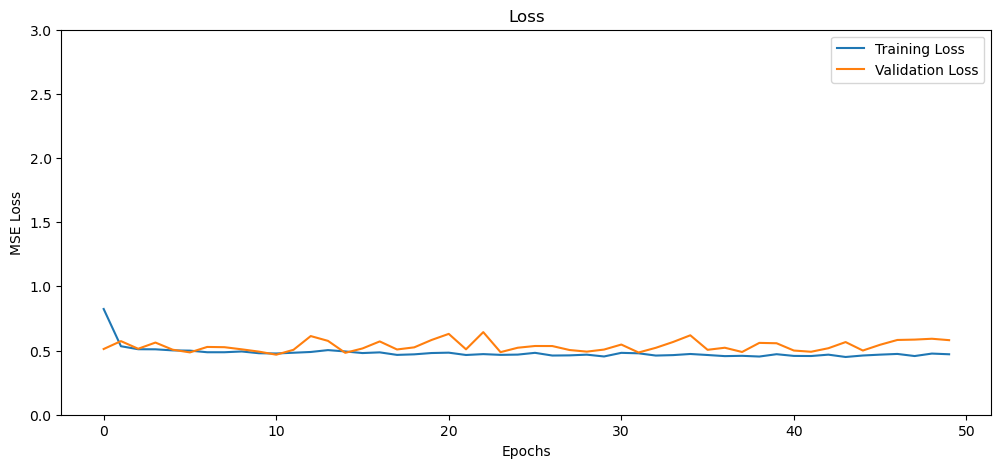

In [10]:
# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")

plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

# Set y-axis limits
plt.ylim(0, 3)

plt.legend()
plt.show()


max frequency 2 + 1 run + half, previously max 1 + half + rescale

Epoch 1
-------------------------------
Train Loss: 1.3323
Validation Loss: 1.2879
Epoch 2
-------------------------------
Train Loss: 1.2981
Validation Loss: 1.1825
Epoch 3
-------------------------------
Train Loss: 1.2932
Validation Loss: 1.3793
Epoch 4
-------------------------------
Train Loss: 1.1906
Validation Loss: 0.8494
Epoch 5
-------------------------------
Train Loss: 0.9394
Validation Loss: 0.6137
Epoch 6
-------------------------------
Train Loss: 1.0505
Validation Loss: 1.1180
Epoch 7
-------------------------------
Train Loss: 0.9840
Validation Loss: 0.7757
Epoch 8
-------------------------------
Train Loss: 0.9407
Validation Loss: 0.8020
Epoch 9
-------------------------------
Train Loss: 1.0396
Validation Loss: 1.2503
Epoch 10
-------------------------------
Train Loss: 1.0568
Validation Loss: 0.8092
Epoch 11
-------------------------------
Train Loss: 1.0362
Validation Loss: 0.9269
Epoch 12
-------------------------------
Train Loss: 0.9799
Validation Loss: 1.1154
E

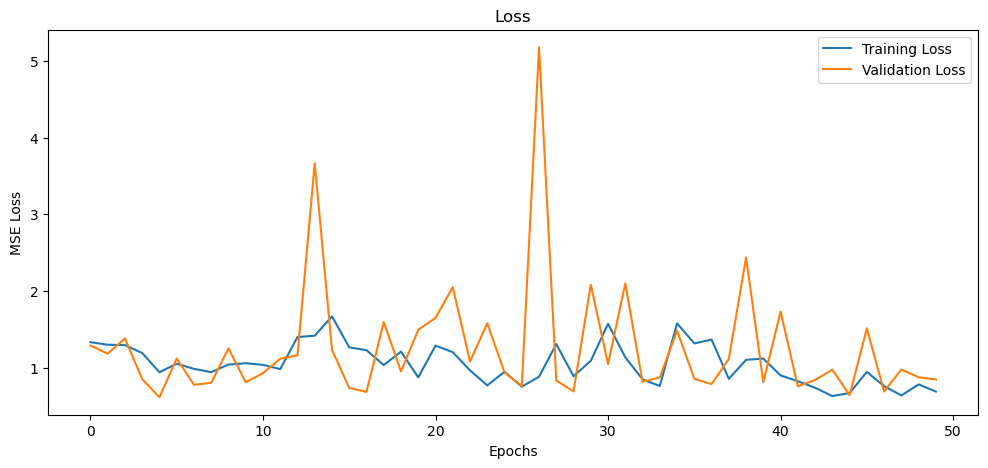

Test Loss: 0.8300


In [13]:

# Generate frequencies
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]

W = utils.freq_generator(max_freq, dim, mode="half").float()

# Initialize the model
model = fm.Fourier_model(W).float()

# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []


# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss = evaluate(val_dataloader, model, loss_fn)  

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
  



# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()


plt.show()

# Evaluate on test data
test_loss = evaluate(test_dataloader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")

all then positive in windoes half several run previously just one run

In [ ]:

# Number of runs
n_runs = 7

# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="all").float()

# Prepare lists to store loss and evaluation metrics for all runs
all_NN_loss = []
all_NN_val_loss = []
all_test_loss = []

epochs = 50

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}\n-------------------------------")


    # Initialize the model
    model = fm.Fourier_model(W).float()

    # Define the loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')

    # Initialize the optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

    # Prepare lists to store loss for this run
    NN_loss = []
    NN_val_loss = []

    # Training loop for this run
    for t in range(epochs):
        print(f"Epoch {t+1}/{epochs}")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        val_loss = evaluate(val_dataloader, model, loss_fn)

        NN_loss.append(train_loss)
        NN_val_loss.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

    # Store losses for this run
    all_NN_loss.append(NN_loss)
    all_NN_val_loss.append(NN_val_loss)

    # Evaluate on test data for this run
    test_loss = evaluate(test_dataloader, model, loss_fn)
    all_test_loss.append(test_loss)
    print(f"Run {run+1} Test Loss: {test_loss:.4f}")

# Plot the training and validation losses for all runs
plt.figure(figsize=(12, 5))
for run in range(n_runs):
    x = np.arange(0, epochs)
    plt.plot(x, all_NN_loss[run], label=f"Run {run+1} Training Loss", color='blue', alpha=0.5)
    plt.plot(x, all_NN_val_loss[run], label=f"Run {run+1} Validation Loss", color='orange', alpha=0.5)

plt.title('Training and Validation Loss Over Multiple Runs')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

# Customizing the legend
handles, labels = plt.gca().get_legend_handles_labels()
label_order = [0, n_runs]  # Picks one label for training and one for validation
plt.legend([handles[idx] for idx in label_order], [labels[idx] for idx in label_order])

plt.show()


# Print average test loss over all runs
average_test_loss = sum(all_test_loss) / n_runs
print(f"Average Test Loss Over {n_runs} Runs: {average_test_loss:.4f}")


In [ ]:

# Number of runs
n_runs = 7

# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="positive").float()

# Prepare lists to store loss and evaluation metrics for all runs
all_NN_loss = []
all_NN_val_loss = []
all_test_loss = []

epochs = 50

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}\n-------------------------------")


    # Initialize the model
    model = fm.Fourier_model(W).float()

    # Define the loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')

    # Initialize the optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

    # Prepare lists to store loss for this run
    NN_loss = []
    NN_val_loss = []

    # Training loop for this run
    for t in range(epochs):
        print(f"Epoch {t+1}/{epochs}")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        val_loss = evaluate(val_dataloader, model, loss_fn)

        NN_loss.append(train_loss)
        NN_val_loss.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

    # Store losses for this run
    all_NN_loss.append(NN_loss)
    all_NN_val_loss.append(NN_val_loss)

    # Evaluate on test data for this run
    test_loss = evaluate(test_dataloader, model, loss_fn)
    all_test_loss.append(test_loss)
    print(f"Run {run+1} Test Loss: {test_loss:.4f}")

# Plot the training and validation losses for all runs
plt.figure(figsize=(12, 5))
for run in range(n_runs):
    x = np.arange(0, epochs)
    plt.plot(x, all_NN_loss[run], label=f"Run {run+1} Training Loss", color='blue', alpha=0.5)
    plt.plot(x, all_NN_val_loss[run], label=f"Run {run+1} Validation Loss", color='orange', alpha=0.5)

plt.title('Training and Validation Loss Over Multiple Runs')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

# Customizing the legend
handles, labels = plt.gca().get_legend_handles_labels()
label_order = [0, n_runs]  # Picks one label for training and one for validation
plt.legend([handles[idx] for idx in label_order], [labels[idx] for idx in label_order])

plt.show()


# Print average test loss over all runs
average_test_loss = sum(all_test_loss) / n_runs
print(f"Average Test Loss Over {n_runs} Runs: {average_test_loss:.4f}")
